In [1]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_rc)
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../../data/rc_circuit'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
window_samples = posterior_metadata['window_samples'] 

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


KeyError: 'window_samples'

In [ ]:
# Parameter bounds
for param_name, param_dict in prior_dict.items():
    print(f'{param_name}:{param_dict["bounds"]}', end=' ')

### Generate conditioning waveform

In [5]:
simulator = partial(simulator_rc, prior_dict=prior_dict, tstop=tstop)

In [1]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.3, 0.5, 0.5]), np.array([0.3, 0.5, 0.75])]

x_cond_list, theta_dict_list = list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['scale_func'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    x_cond = simulator(torch.tensor(theta_cond).float())
    x_cond = x_cond[:, window_samples[0]:window_samples[1]]
                   
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond.T)


NameError: name 'np' is not defined

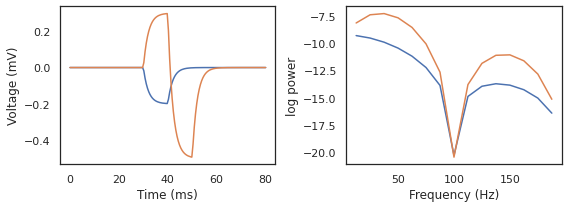

In [7]:
%matplotlib inline

x_cond_psd0, f = get_dataset_psd(x_cond_list[0], posterior_metadata['fs'])
x_cond_psd1, _ = get_dataset_psd(x_cond_list[1], posterior_metadata['fs'])

t_vec = np.linspace(0, tstop, x_cond_list[0].squeeze().shape[0])
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t_vec, x_cond_list[0].squeeze())
plt.plot(t_vec, x_cond_list[1].squeeze())
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.subplot(1,2,2)
plt.plot(f, x_cond_psd0.squeeze())
plt.plot(f, x_cond_psd1.squeeze())
plt.xlabel('Frequency (Hz)')
plt.ylabel('log power')

plt.tight_layout()

### Load trained posterior objects

In [8]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')

posterior_names = list(posterior_state_dicts.keys())

# Pick posterior to load
name_idx = 0

input_type = posterior_names[name_idx]
posterior_dict = posterior_state_dicts[input_type]
state_dict = posterior_dict['posterior']
n_params = posterior_dict['n_params']
n_sims = posterior_dict['n_sims']
input_dict = posterior_dict['input_dict']

embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

print(posterior_names)

['raw_waveform', 'pca4', 'pca30', 'peak', 'psd', 'psd_peak']


In [7]:
print(f'Conditioning Feature: {posterior_names[name_idx]}')

num_samples = 1000
all_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

df_list, theta_cond_transformed_list = list(), list()
cond_name = ['Large', 'Small']
for x_cond, cond_name, theta_cond in zip(x_cond_list, cond_name, theta_cond_list):
    load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                        'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
                 for name, posterior_dict in posterior_state_dicts.items()}
    posterior = load_posterior(state_dict=state_dict,
                               x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                               theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)
    
    samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
    samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

    theta_cond_transformed = linear_scale_array(theta_cond.reshape(1,-1), all_bounds)[0]
    df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
    df_dict['cond_name'] = np.repeat(cond_name, num_samples)

    df_temp = pd.DataFrame(df_dict)
    
    theta_cond_transformed_list.append(theta_cond_transformed)
    df_list.append(df_temp)
df = pd.concat(df_list)

Conditioning Feature: pca30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
df.columns = ['Amp 1 (mA)', 'Amp 2 (mA)', 'Latency (ms)', 'cond_name']

### Draw samples and plot

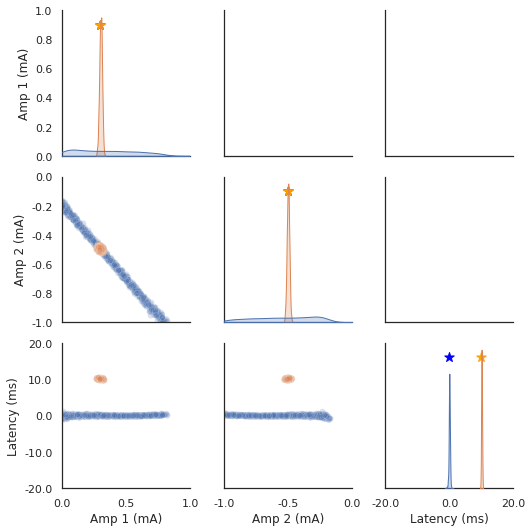

In [50]:
g = sns.PairGrid(df, hue='cond_name', diag_sharey=False, corner=False)
g.map_lower(sns.scatterplot, alpha=0.2)
#g.map_upper(sns.kdeplot, fill=False)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(3):    
    # Add space to visuzalize groundtruth tick marks at top
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])
    
    g.axes[idx,idx].scatter(theta_cond_transformed_list[0][idx], all_bounds[idx][1] - y_diff*0.1,
                            color='blue', marker='*', s=100)
    g.axes[idx,idx].scatter(theta_cond_transformed_list[1][idx], all_bounds[idx][1] - y_diff*0.1,
                            color='orange', marker='*', s=100)

for idx1 in range(3):
    for idx2 in range(3):
        if g.axes[idx1, idx2] != None:
            g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()